In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import torch
from sys import getsizeof
import matplotlib.pyplot as plt
from my_functions import FokkerPlankCalculator, get_pos, get_pos_with_border
# from scipy.linalg import expm
# from tqdm.notebook import tqdm
import yaml
from pathlib import Path
import pickle

In [2]:
max_t = 4
#avarage = 100
x_range = (-4e-3,4e-3)
dx = 0.00004
tau = 0.4 #0.3 #0.1 #0.05#0.1
D = 1e-6
k = 3
dt = 1e-3 * 4

t_idx = 400

F_ext = lambda t:0

boundary = 'reflective' #'absorbing'

In [3]:
ntau = int(tau/dt)
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)
num_particle = 80_000

if boundary == 'reflective':
    pos = get_pos(
            num_particle=num_particle,
            max_t = max_t+tau,
            dt = dt,
            tau=tau,
            k=k,
            D=D,
            F=lambda t:0)[ntau:]

100


In [4]:
hists = np.stack([np.histogram(o, bins=x_s)[0]/num_particle*1/dx for o in pos])
#sim_num_particle = hists.sum(1)
#sim_rate = -np.diff(sim_num_particle)/sim_num_particle[1:]/dt

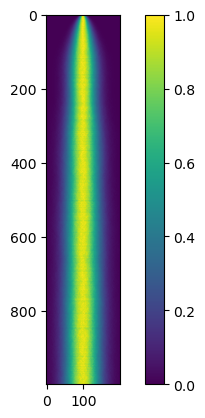

In [5]:
plt.imshow((hists/hists.max(axis=1)[:,None]))
plt.colorbar()

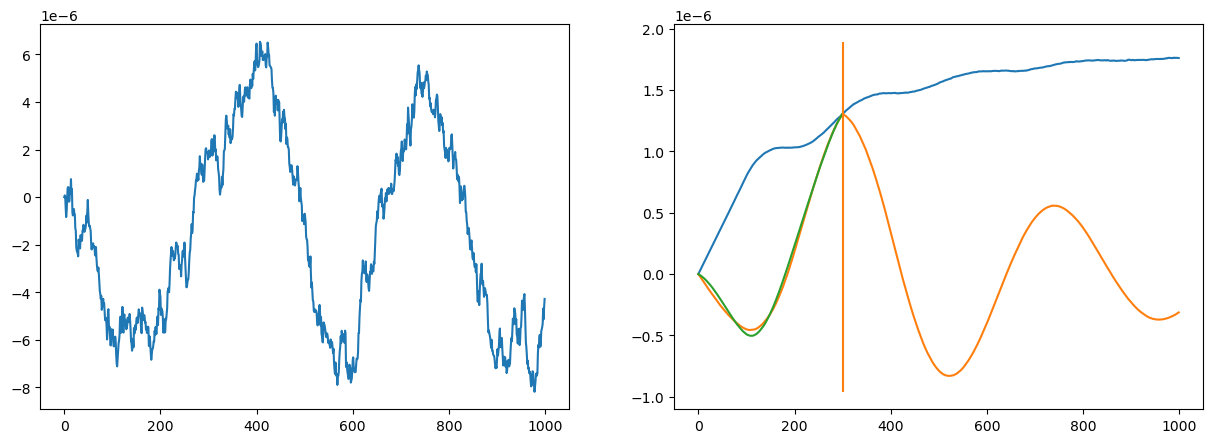

In [17]:
sim_mean = torch.mean(pos[:,:,0], axis = 1)
sim_var = torch.var(pos[:,:,0], axis = 1)
full_cov = torch.mean(pos[t_idx-ntau] * pos, axis=1)
ana_cov = [np.full(ntau, 1)]
for i in range(10):
    ana_cov[0] = ana_cov[0][0] - k * np.cumsum(ana_cov[0][::-1]) * dt
ana_cov[0] = ana_cov[0]/ana_cov[0][0]
max_order = int((t_idx-ntau)/ntau)
for j in range(1,max_order):
    ana_cov.append(ana_cov[j-1][-1] - k * np.cumsum(ana_cov[j-1]) * dt)
ana_cov = np.concatenate(ana_cov)[::-1]
ana_cov = ana_cov*sim_var[:t_idx-ntau].numpy()


fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(sim_mean)
axs[1].plot(sim_var)
axs[1].plot(full_cov)
axs[1].plot(np.arange(t_idx-ntau-len(ana_cov),t_idx-ntau, 1), ana_cov ,c='C2')
axs[1].vlines([t_idx-ntau], *plt.ylim(), color='C1')
#axs[1].set_xlim(600,800)

In [7]:
def get_realisations_through_point(t_idx,x_idx):
    x_f, x_t = x_s[x_idx],x_s[x_idx+1]
    my_filter = (pos[t_idx] > x_f) * (pos[t_idx] < x_t)
    return pos[:,my_filter]

In [8]:

#x_idx = 100
filter_x_idxs = np.arange(40,len(x_s)-41,5)
pos_filtered = [get_realisations_through_point(t_idx,x_idx) for x_idx in filter_x_idxs]
hists_filterd = [np.stack([np.histogram(o, bins=x_s)[0]/data.shape[1]*1/dx for o in data]) for data in pos_filtered]

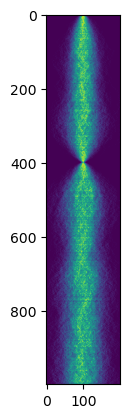

In [9]:
idx = 12
plt.imshow((hists_filterd[idx]/hists_filterd[idx].max(axis=1)[:,None]))

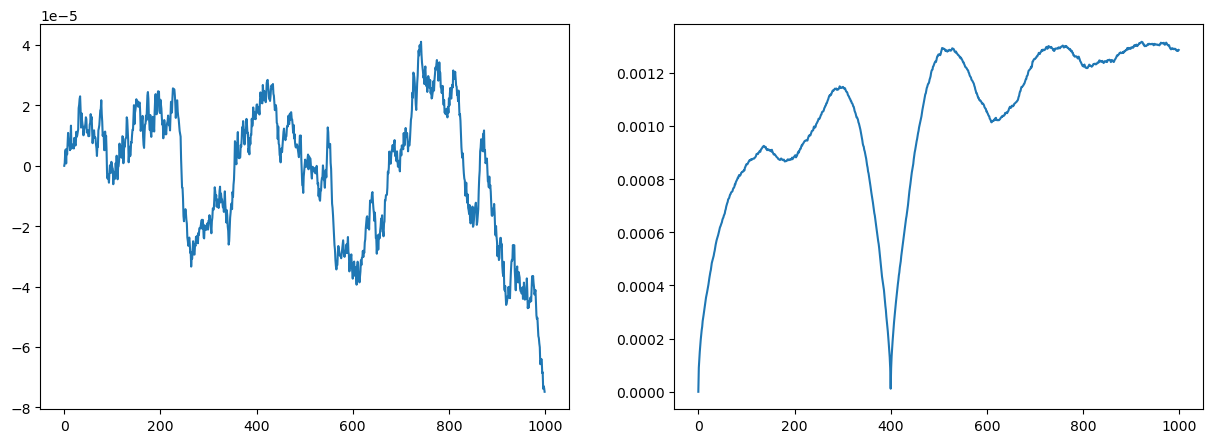

In [10]:
sim_f_mean = [torch.mean(data, axis = 1) for data in pos_filtered]
sim_f_var = [torch.var(data, axis = 1) for data in pos_filtered]

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(sim_f_mean[idx])
axs[1].plot(np.sqrt(sim_f_var[idx]))

In [11]:
pos_noise = [data - mean[:,None] for data, mean in zip(pos_filtered, sim_f_mean)]
hists_noise = [np.stack([np.histogram(o, bins=x_s)[0]/data.shape[1]*1/dx for o in data]) for data in pos_noise]

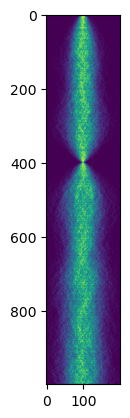

In [12]:
plt.imshow((hists_noise[idx]/hists_noise[idx].max(axis=1)[:,None]))

In [13]:
cov = [torch.mean(data[t_idx-ntau] * data, axis=1) for data in pos_noise]

In [14]:
s = torch.arange(0,t_idx-ntau+1/2)
C_theo = torch.exp(-k*(t_idx-ntau-s)*dt)

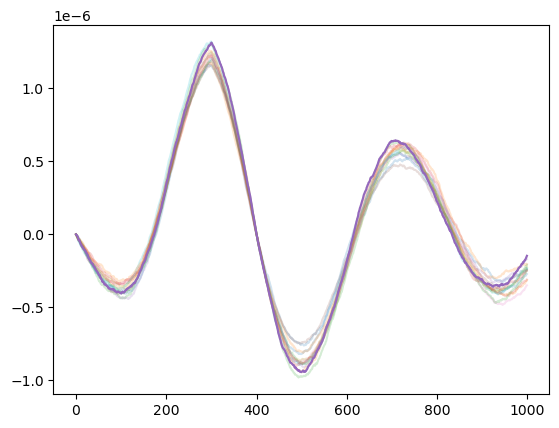

In [15]:
border_i = 5
for c in cov[border_i:-border_i]:
    plt.plot(c, alpha =0.2)
plt.plot(cov[idx])

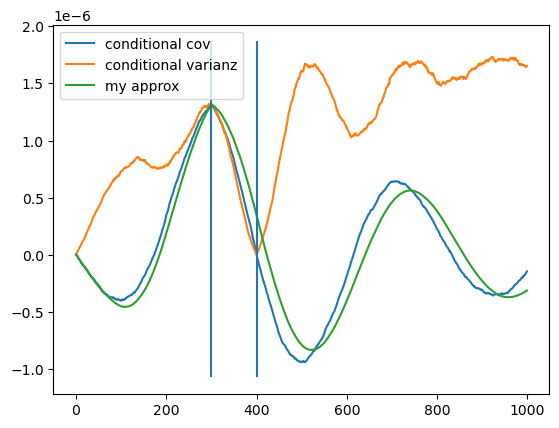

In [16]:
#cov_approx = (sim_f_var[idx] * full_cov[:,0] / full_cov[t_idx-ntau,0])
cov_approx = (sim_f_var[idx][t_idx-ntau] * full_cov[:,0] / full_cov[t_idx-ntau,0])

plt.plot(cov[idx], label='conditional cov')
#plt.plot(full_cov)
plt.plot(sim_f_var[idx], label='conditional varianz')
plt.plot(cov_approx, label='my approx')
#plt.plot(C_theo*sim_f_var[idx][t_idx-ntau])
plt.vlines([t_idx, t_idx-ntau],*plt.ylim() )
#plt.xlim(200,t_idx+50)
plt.legend()